# Validation
In this exercise, we'll dive a bit more deeply into the training and evaluation of a model.

As in the prior exercises, we're working with the California housing data set, to try and predict `median_house_value` at the city block level from 1990 census data.

In this exercise, we'll use multiple features (instead of a single feature), and also get familiar with the train / validation / test split methodology.

First off, let's load up and prepare our data.

In [15]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("C:\\Users\\lovebird\\test\\tensorflow\\california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
     np.random.permutation(california_housing_dataframe.index))

In [16]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

For the **training set**, we'll choose the first 12000 examples, out of the total of 17000.

In [17]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2639.7,538.4,1429.8,501.0,3.9,2.0
std,2.1,2.0,12.6,2178.2,422.3,1162.7,386.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,296.0,786.8,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2127.0,434.0,1168.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3142.0,647.0,1722.0,603.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [18]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,206.4
std,115.6
min,17.5
25%,118.8
50%,179.2
75%,264.3
max,500.0


For the **validation set**, we'll choose the last 5000 examples, out of the total of 17000.

In [19]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.7,2653.3,541.8,1429.0,501.8,3.9,2.0
std,2.1,2.0,12.6,2184.2,419.6,1111.5,381.0,1.9,1.0
min,32.5,-124.3,2.0,12.0,3.0,8.0,3.0,0.5,0.1
25%,33.9,-121.6,18.0,1464.0,298.0,796.8,282.0,2.5,1.5
50%,34.2,-118.4,29.0,2129.0,434.0,1163.5,409.5,3.5,1.9
75%,37.7,-118.0,37.0,3164.0,655.0,1714.2,608.0,4.8,2.3
max,42.0,-114.6,52.0,32054.0,5290.0,15507.0,5050.0,15.0,22.6


In [20]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,209.5
std,116.9
min,15.0
25%,121.2
50%,182.3
75%,266.7
max,500.0


### Examine the data
Okay, let's look at the data above. We have `9` input features that we can use.

**Take a quick skim over the table of values. Do they pass a quick sanity check?**

Take a look at the data on your own. Everything look okay? See how many issues you can spot. Don't worry if you don't have a background in statistics; common sense is often enough.

After you've had a chance to look over the data yourself, check the solution for some additional thoughts on how to sanity check data.

Let's take a close look at two features in particular: **`latitude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot `latitude` and `longitude`, and use color to show the `median_house_value`.

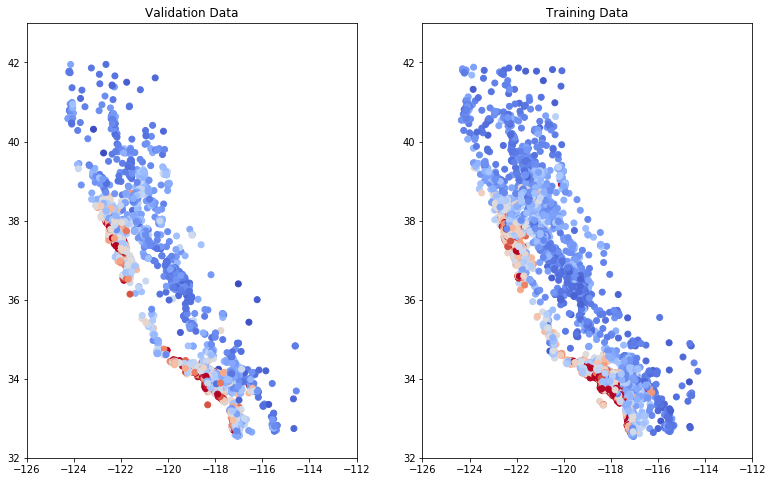

In [21]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

Wait a second ... this should have given us a nice map of the state of California, with red showing up in expensive areas like the San Francisco and Los Angeles.

The training set sort of does, compared to a [real map](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), but the validation set clearly doesn't.

**Go back up and look at the sanity check data again.**

Do you see any other differences in the distributions of features or targets between the training and validation data?

Check the solution to view the key issue.

### Task 1:  Go back up to the data importing and pre-processing code, and see if you spot any bugs there.
If you do, go ahead and fix the bug. Don't spend more than a minute or two looking. If you can't find the bug, check the solution for a hint.

When you've found and fixed the issue, re-run `latitude` / `longitude` plotting cell above and confirm that our sanity checks look better.

By the way, there's an important lesson here.

**Debugging in ML is often *data debugging* rather than code debugging.**

If the data is wrong, even the most advanced ML code can't save things.

### Task 2: Train and evaluate a model.

**Spend 5 minutes or so trying different hyperparameter settings.  Try to get the best validation performance you can.**

Go ahead and write some code to set up a linear_regressor, using the `LinearRegressor` interface provided by the TensorFlow Estimators library.

It's okay to use the code in the previous exercises, but you'll want to call `fit()` and `predict()` on the appropriate data sets.

Using multiple input features instead of a single feature doesn't require anything special; the Estimators interface accepts Pandas `DataFrame` objects.

If the `DataFrame` has multiple features defined (as ours does) these will all be used.

Compare the losses on training data and validation data.

With a single raw feature, our best root mean squared error (RMSE) was of about 180.

See how much better you can do now that we can use multiple features.

Use some of the sanity-checking methods we've looked at before.  These might include:

   * comparing distributions of predictions and actual target values

   * creating a scatter plot of predictions vs. target values

   * creating two scatter plots of validation data using `latitude` and `longitude`:
      * one plot mapping color to actual target `median_house_value`
      * a second plot mapping color to predicted `median_house_value` for side-by-side comparison.


In [ ]:
#
# Your code here
#

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)


train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

### Task 3: Evaluate on test data.

**In the cell below, load in the test data set and evaluate your model on it.**

We've done a lot of iteration on our validation data.  Let's make sure we haven't overfit to the pecularities of that particular sample.

Test data set is located [here](https://storage.googleapis.com/ml_universities/california_housing_test.csv).

How does your test performance compare to the validation performance?  What does this say about the generalization performance of your model?

In [ ]:
#
# Your code here
#